<h2>Imports</h2>

In [1]:
import torch
from sklearn.metrics import accuracy_score
import segmentation_models_pytorch as smp
from transformers import SamProcessor
from transformers import SamModel
import numpy as np
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
import os
import re
import albumentations as A
from skimage.io import imread, imshow
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from numpy import save
from numpy import load
from imports import *
from data import *
from dataloader import *
from utils import accuracy_npthresh,accuracy_npthresh_micro,remove_element
from data import data
from utils import accuracy,remove_indices
from data_utils import *
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
from skimage.measure import label, regionprops
import random

2023-08-14 10:29:35.301970: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-14 10:29:35.342674: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-14 10:29:35.925564: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

<h2>Utils</h2>

In [3]:
def bboxes_from_mask(mask):
    binary_image = np.squeeze(mask)
    labeled_image = label(binary_image)
    regions = regionprops(labeled_image)

    # Create a list to store bounding boxes
    bounding_boxes = []
    areas = []
    label_list = []

    # Iterate over the labeled regions
    for region in regions:
        label_value = region.label
        centroid = region.centroid
        area = region.area
        bbox = region.bbox
        bounding_boxes.append(bbox)
        areas.append(area)
        label_list.append(label_value)

    
    target = {}
    target["boxes"] = bounding_boxes
    target["labels"] = label_list
    target["label_img"] = labeled_image
    target["mask"] = binary_image
    target["area"] = areas

    return target

def show_single_bbox(binary_image, labeled_image, bounding_boxes,i):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5),gridspec_kw={'width_ratios': [1, 1]})

    # Plot the labeled image
    axes[0].imshow(labeled_image)
    axes[0].set_title("Labeled Image")

    # Plot the binary image
    axes[1].imshow(binary_image, cmap='gray')
    axes[1].set_title("Binary Image")

    # Plot bounding boxes as rectangles
    # for bbox in bounding_boxes:


    min_row, min_col, max_row, max_col = bounding_boxes[i]
    rect = plt.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
                        fill=False, edgecolor='red', linewidth=2)
    axes[1].add_patch(rect)

    axes[1].set_title("Binary Image with Bounding Boxes")

    # Remove x and y ticks
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    # Show the plot
    plt.tight_layout()
    plt.show()

def show(binary_image, labeled_image, bounding_boxes):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a row of 3 subplots

    # Plot the labeled image
    axes[0].imshow(labeled_image)
    axes[0].set_title("Labeled Image")

    # Plot the binary image
    axes[1].imshow(binary_image, cmap='gray')
    axes[1].set_title("Binary Image")

    # Plot bounding boxes as rectangles on the binary image
    axes[2].imshow(binary_image, cmap='gray')  # Reuse the binary image plot
    for bbox in bounding_boxes:
        min_row, min_col, max_row, max_col = bbox
        rect = plt.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
                                  fill=False, edgecolor='red', linewidth=2)
        axes[2].add_patch(rect)

    axes[2].set_title("Binary Image with Bounding Boxes")

    # Remove x and y ticks from all axes
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

def calculate_iou(box1, box2):
    # Calculate the Intersection over Union (IoU) between two bounding boxes
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    intersection_area = max(0, min(x1 + w1, x2 + w2) - max(x1, x2)) * \
                        max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
    
    area_box1 = w1 * h1
    area_box2 = w2 * h2
    
    iou = intersection_area / (area_box1 + area_box2 - intersection_area)
    return iou

def eliminate_overlapping_boxes(boxes, threshold=0.5):
    # Eliminate overlapping bounding boxes from the input list
    result = []
    for i, box in enumerate(boxes):
        is_overlapping = False
        for j, existing_box in enumerate(result):
            iou = calculate_iou(box, existing_box)
            if iou > threshold:
                is_overlapping = True
                break
        if not is_overlapping:
            result.append(box)
    return result

<h2>Loading Models</h2>

In [4]:
# path to the resunet model
resunet_model_path = '/home/prateekjha/Anit/ai4boundaries/SAM_finetune/resunet_model_ai4boundaries.pt'
sam_model_path ='/home/prateekjha/Anit/ai4boundaries/SAM_finetune/saved_models/SAM_finetune_model_ai4boundaries_input_mask.pt'


model_runet = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

# Load the model
model_runet.load_state_dict(torch.load(resunet_model_path))
model_runet.eval()


# Load the model
model_runet.load_state_dict(torch.load(resunet_model_path))
for name,param in model_runet.named_parameters():
  param.requires_grad_(False)

model_runet.eval()

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
model_sam = SamModel.from_pretrained("facebook/sam-vit-base")
# model_sam.load_state_dict(torch.load(sam_model_path))
model_sam=model_sam.to(device)


<h2>Loading data</h2>

In [5]:
X_train = np.load('X_train.npy')
Y_train = np.load('Y_train.npy')
X_val = np.load('X_val.npy')
Y_val = np.load('Y_val.npy')
X_test = np.load('X_test.npy')
Y_test = np.load('Y_test.npy')

Y_train = np.expand_dims(Y_train, axis=-1)
Y_val = np.expand_dims(Y_val, axis=-1)
Y_test = np.expand_dims(Y_test, axis=-1)

# Get the shape of X_train
X_train_shape = X_train.shape
Y_train_shape = Y_train.shape
X_val_shape = X_val.shape
Y_val_shape = Y_val.shape
X_test_shape = X_test.shape
Y_test_shape = Y_test.shape


print("Shape of X_train",X_train_shape)
print("Shape of Y_train",Y_train_shape)
print("Shape of X_val",X_val_shape)
print("Shape of Y_val",Y_val_shape)
print("Shape of X_test",X_test_shape)
print("Shape of Y_test",Y_test_shape)


train_indices,val_indices,test_indices = remove_indices(Y_train,Y_val,Y_test)

X_train = remove_element(train_indices,X_train)
Y_train = remove_element(train_indices,Y_train)
X_val = remove_element(val_indices,X_val)
Y_val = remove_element(val_indices,Y_val)
X_test = remove_element(test_indices,X_test)
Y_test = remove_element(test_indices,Y_test)

X_train_shape = X_train.shape
Y_train_shape = Y_train.shape
X_val_shape = X_val.shape
Y_val_shape = Y_val.shape
X_test_shape = X_test.shape
Y_test_shape = Y_test.shape

print("New Shape of X_train",X_train_shape)
print("New Shape of Y_train",Y_train_shape)
print("New Shape of X_val",X_val_shape)
print("New Shape of Y_val",Y_val_shape)
print("New Shape of X_test",X_test_shape)
print("New Shape of Y_test",Y_test_shape)


Shape of X_train (5319, 256, 256, 3)
Shape of Y_train (5319, 256, 256, 1)
Shape of X_val (1140, 256, 256, 3)
Shape of Y_val (1140, 256, 256, 1)
Shape of X_test (1139, 256, 256, 3)
Shape of Y_test (1139, 256, 256, 1)
New Shape of X_train (5078, 256, 256, 3)
New Shape of Y_train (5078, 256, 256, 1)
New Shape of X_val (1087, 256, 256, 3)
New Shape of Y_val (1087, 256, 256, 1)
New Shape of X_test (1095, 256, 256, 3)
New Shape of Y_test (1095, 256, 256, 1)


<h2>Dataloader</h2>

In [6]:
# Create custom datasets
train_dataset = CustomDataset(X_train, Y_train)
val_dataset = CustomDataset(X_val, Y_val)
test_dataset = CustomDataset(X_test,Y_test)

batch_size = 1
train_loader,val_loader,test_loader = dataloader(train_dataset,val_dataset,test_dataset,batch_size)


<h2>Inferecing the results</h2>

<h3>For a single image</h3>

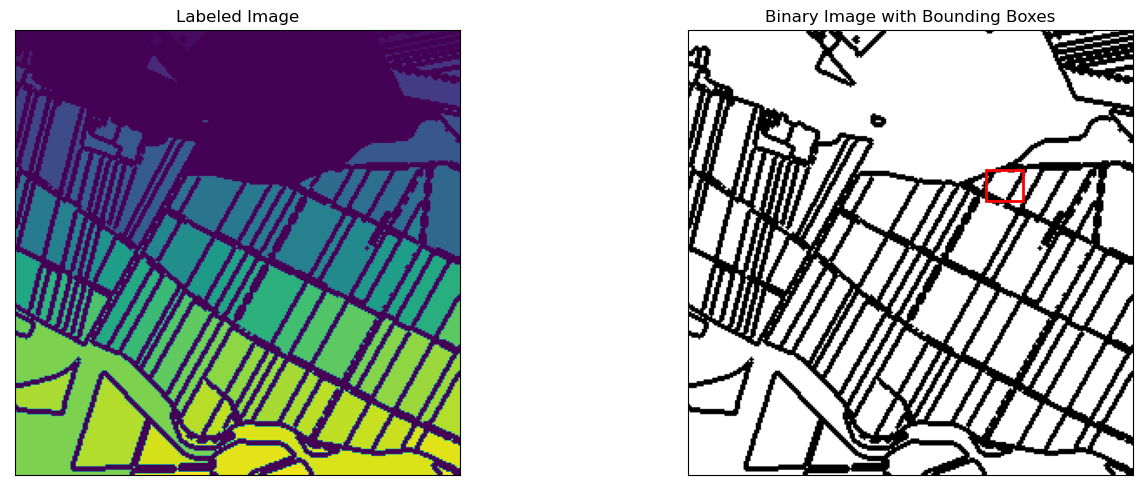

[80, 171, 98, 192]

In [8]:
i = 69

# i =50 is working somehow
# i = 53 is completely fucked somehow

batch = next(iter(test_loader))
inputs, targets = batch[0].to(device), batch[1].to(device) 
targets = torch.permute(targets,(0,3,1,2))
targets = targets.detach().cpu().numpy().squeeze()

target = bboxes_from_mask(targets)
bboxes=target["boxes"]
labeled_img = target["label_img"]
show_single_bbox(targets,labeled_img,bboxes,i)


# Using a list comprehension
list_of_lists = [list(tup) for tup in bboxes]

bbox = list(bboxes[i])
bbox

<h2>Distribution of bounding_boxes based on area</h2>

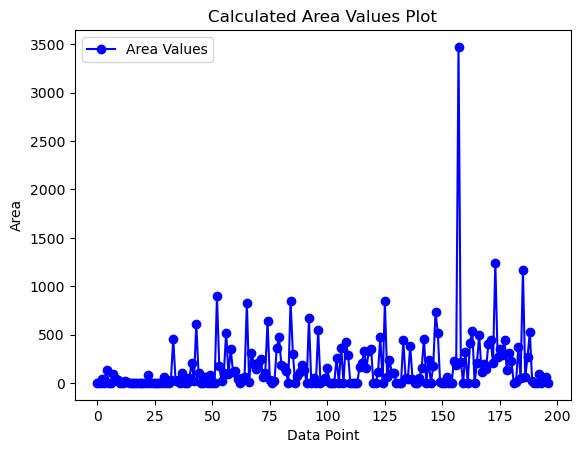

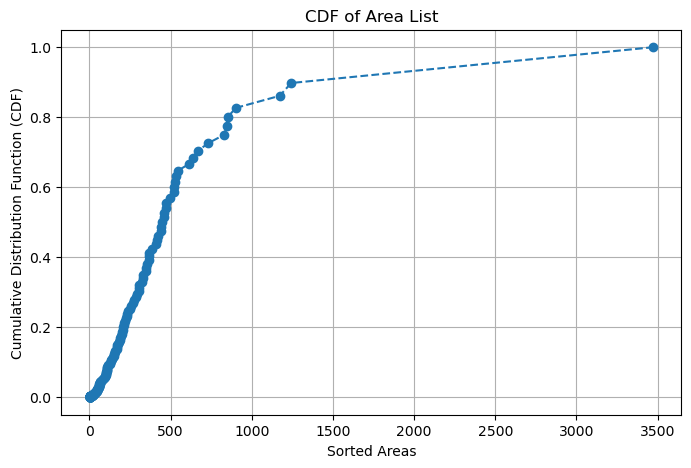

In [11]:
area=target['area']
area = area[1:]

# Create a line plot of the area values
plt.plot(area, marker='o', color='blue', label='Area Values')

# Add labels and title
plt.xlabel('Data Point')
plt.ylabel('Area')
plt.title('Calculated Area Values Plot')
plt.legend()

# Display the plot
plt.show()

# Step 1: Sort the list in increasing order
sorted_area_list = sorted(area)

# Step 2: Calculate the cumulative distribution function (CDF)
total_area = sum(sorted_area_list)
cdf = np.cumsum(sorted_area_list) / total_area

# Step 3: Plot the CDF
plt.figure(figsize=(8, 5))
plt.plot(sorted_area_list, cdf, marker='o', linestyle='--')
plt.xlabel('Sorted Areas')
plt.ylabel('Cumulative Distribution Function (CDF)')
plt.title('CDF of Area List')
plt.grid(True)
plt.show()

<h2>Code to eliminate overlapping bounding_boxes</h2>

Original bounding boxes: [(0, 0, 88, 244), (0, 71, 1, 72), (0, 75, 1, 76), (0, 78, 10, 85), (0, 84, 1, 85), (0, 88, 12, 111), (0, 206, 1, 207), (0, 208, 2, 210), (0, 209, 9, 248), (2, 213, 11, 256), (6, 228, 12, 256), (10, 253, 11, 254), (11, 248, 12, 249), (12, 0, 19, 5), (12, 7, 20, 10), (12, 223, 13, 227), (12, 243, 13, 244), (13, 218, 14, 222), (13, 238, 14, 239), (13, 254, 14, 256), (14, 213, 16, 217), (14, 233, 15, 234), (14, 249, 15, 251), (15, 76, 30, 93), (15, 227, 16, 229), (15, 244, 16, 246), (16, 222, 17, 223), (16, 239, 17, 241), (17, 215, 19, 218), (17, 234, 18, 236), (17, 231, 23, 256), (18, 229, 19, 231), (19, 223, 21, 225), (21, 0, 30, 6), (22, 216, 44, 256), (23, 245, 27, 256), (25, 6, 35, 15), (32, 0, 33, 1), (32, 0, 62, 7), (33, 17, 34, 18), (34, 20, 35, 21), (36, 0, 76, 11), (38, 3, 81, 18), (40, 17, 57, 22), (41, 14, 92, 38), (45, 27, 96, 41), (45, 247, 46, 249), (46, 252, 47, 254), (48, 245, 60, 256), (50, 45, 51, 46), (50, 46, 63, 59), (51, 48, 52, 49), (52, 108

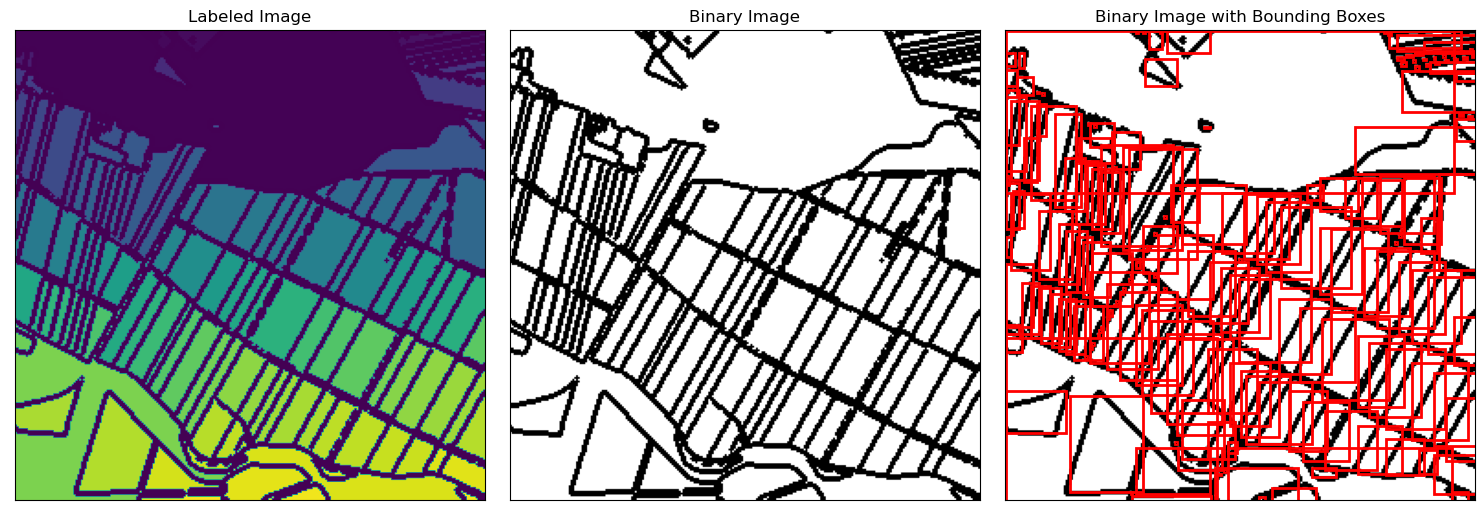

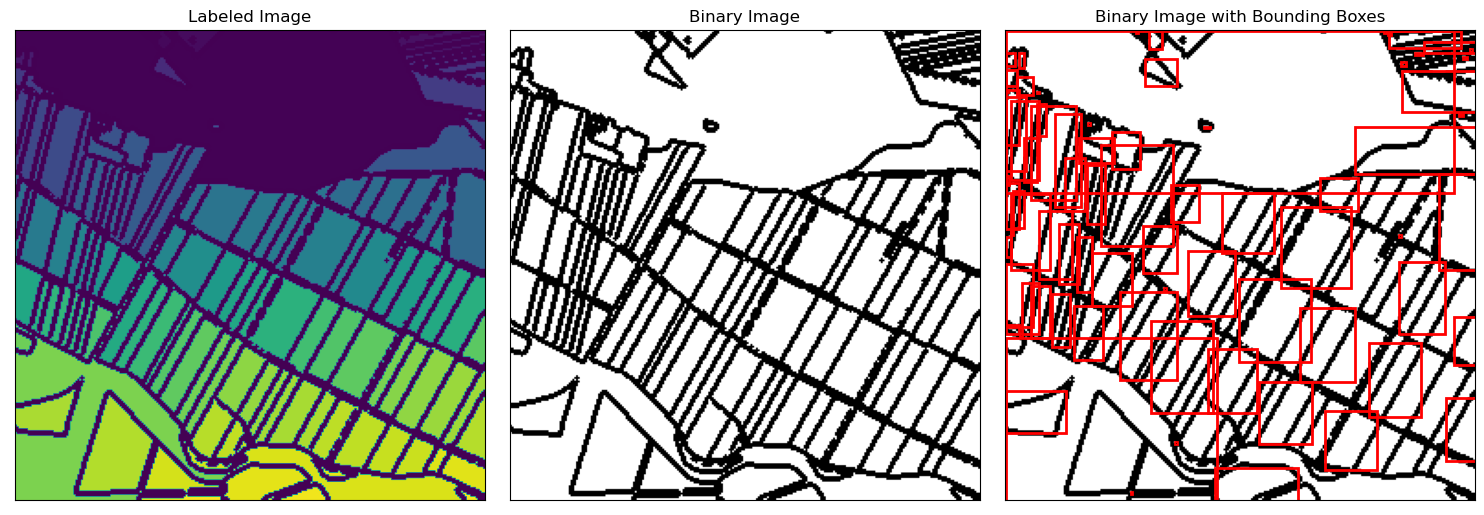

In [8]:

# Eliminate overlapping bounding boxes
non_overlapping_boxes = eliminate_overlapping_boxes(bboxes,0.5)

print("Original bounding boxes:", bboxes)
print("Non-overlapping bounding boxes:", non_overlapping_boxes)

print(len(bboxes))
print(len(non_overlapping_boxes))


show(targets,labeled_img,bboxes)
show(targets,labeled_img,non_overlapping_boxes)


<h2>Generate grid points</h2>

In [11]:
import numpy as np

# Image size
img_size = (256, 256)

# Grid dimensions
grid_rows = 5
grid_cols = 5

# Calculate the size of each grid cell
grid_cell_width = img_size[0] // grid_cols
grid_cell_height = img_size[1] // grid_rows

# Calculate the centroids of each grid cell
centroid_points = []
for row in range(grid_rows):
    for col in range(grid_cols):
        centroid_x = col * grid_cell_width + grid_cell_width // 2
        centroid_y = row * grid_cell_height + grid_cell_height // 2
        centroid_points.append([centroid_x, centroid_y])

# centroid_points = np.array(centroid_points)

<h2>Inferencing single bbox prompt output</h2>

In [42]:
model_runet.to(device)
model_runet.eval()

threshold=0.5
count=0
batch = next(iter(test_loader))
inputs, targets = batch[0].to(device), batch[1].to(device)    
targets = torch.permute(targets,(0,3,1,2))

inputs= torch.permute(inputs,(0,3,1,2))
inputs = inputs.float()
outputs = model_runet(inputs)

targets = targets.detach().cpu().numpy().squeeze()
inputs = inputs.cpu().detach().numpy().squeeze(0)
inputs = inputs.transpose(1,2,0)
outputs = outputs.detach().cpu().numpy().squeeze(0)

target = bboxes_from_mask(targets)
bboxes=target["boxes"]
labeled_img = target["label_img"]
# show_single_bbox(targets,labeled_img,bboxes,i)

# Initialize a variable to hold the accumulated mask
final_mask = None

random.shuffle(bboxes)

for i,bbox in enumerate(bboxes): 
    # print(bbox,i)
    # inputs_sam = processor(inputs,input_boxes=[[[128, 64, 256, 128]]], return_tensors="pt").to(device)
    # inputs_sam = processor(inputs, input_boxes=[list_of_lists], return_tensors="pt").to(device)

    min_row,min_col,max_row,max_col = bbox
    updated_bbox = (min_col,min_row,max_col,max_row)
    # inputs_sam = processor(inputs, input_boxes=[[list(updated_bbox)]], return_tensors="pt").to(device)
    inputs_sam = processor(inputs,input_points=[ip],return_tensors="pt").to(device)
    # outputs_sam = model_sam(**inputs_sam, input_masks=[outputs], multimask_output=False)
    outputs_sam = model_sam(**inputs_sam, multimask_output=False)
    # print(outputs_sam.pred_masks.shape)
    geo_sam=torch.sigmoid(outputs_sam.pred_masks.squeeze(0).squeeze(0))
    # print(geo_sam.shape)
    geo_sam = geo_sam.cpu().detach().numpy().squeeze(0)
    # print(geo_sam.shape)

     
    # Accumulate the masks
    if final_mask is None:
        final_mask = geo_sam>0.5
    else:
        final_mask += geo_sam>0.5
    
    #Code for plotting

    # fig,axes=plt.subplots(1,4,figsize=(15, 5))
    # axes[0].imshow((inputs).astype('uint8'))    # plt.imshow(mask)
    # axes[1].imshow(targets)
    # axes[2].imshow(targets, cmap='gray')  # Reuse the binary image plot
    # min_row, min_col, max_row, max_col = list(bbox)
    # rect = plt.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
    #             fill=False, edgecolor='red', linewidth=2)
    # axes[2].add_patch(rect)
    # axes[3].imshow(geo_sam)
    # plt.show()

    # count+=1
    # if(count>40):
    #     break



In [9]:
def accuracy(outputs,targets):
   

    # Flatten the array
    output_flattened_array = outputs.flatten()
    targets_flattened_array = targets.flatten()

    threshold = 0.5

    output_flattened_array = np.where(output_flattened_array > threshold, 1, 0)
    targets_flattened_array = np.where(targets_flattened_array > threshold, 1, 0)

    f1 = f1_score(targets_flattened_array, output_flattened_array)

    return f1

In [39]:
output = outputs.squeeze(0)
output.shape

inputs.shape


(256, 256, 3)

In [48]:
score = accuracy(targets,output)
print(score)

0.849981901742917


<h2>Inferencing full_mask with bbox as prompt</h2>

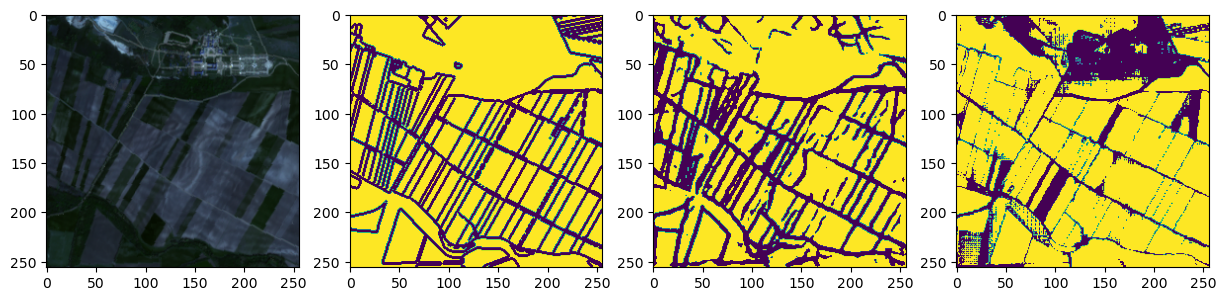

In [44]:
# Apply thresholding to the accumulated mask
final_mask = np.where(final_mask > threshold, 1, 0)

fig,axes=plt.subplots(1,4,figsize=(15, 5))
axes[0].imshow(inputs.astype('uint8'))
axes[1].imshow(targets)
axes[2].imshow(output>0.5)
axes[3].imshow(final_mask)
plt.show()

<h2>Sam Model processor output</h2>

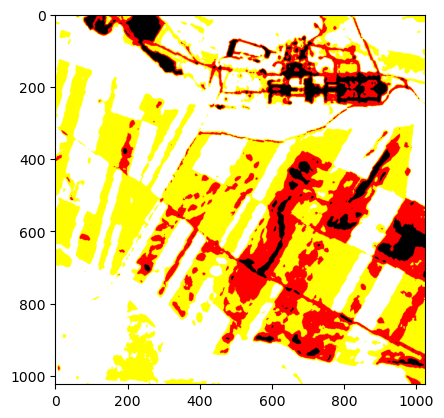

In [31]:
processor_img=inputs_sam['pixel_values'].squeeze(0).permute(1,2,0).cpu().detach().numpy()
processor_img.shape

# print(processor_img)
plt.imshow(processor_img.astype('uint8'))
plt.show()

<h3>For a batch of imgs/ Grid of Points</h3>

In [12]:
model_runet.to(device)
model_runet.eval()

# Assume you have a DataLoader object called 'dataloader'

threshold =0.5
count=0

score = []

for batch in test_loader:

    inputs, targets = batch[0].to(device), batch[1].to(device)    
    targets = torch.permute(targets,(0,3,1,2))

    inputs= torch.permute(inputs,(0,3,1,2))
    inputs = inputs.float()
    outputs = model_runet(inputs)

    # inputs_sam = processor(inputs,input_boxes=[[0,0,128,128]] return_tensors="pt").to(device)
    inputs_sam = processor(inputs, input_boxes=[[[0,0,128,128]]], return_tensors="pt").to(device)
    inputs_sam = processor(inputs,input_points=[centroid_points],return_tensors="pt").to(device)
    # outputs_sam = model_sam(**inputs_sam, input_masks=[outputs], multimask_output=False)
    outputs_sam = model_sam(**inputs_sam, multimask_output=False)
    geo_sam=torch.sigmoid(outputs_sam.pred_masks.squeeze(1))
    geo_sam = geo_sam.cpu().detach().numpy().squeeze()
    
    inputs = inputs.cpu().detach().numpy().squeeze()
    inputs = inputs.transpose(1,2,0)
    targets = targets.detach().cpu().numpy().squeeze()
    outputs = outputs.detach().cpu().numpy().squeeze()

    # score.append(accuracy(targets,outputs))
    #Code for plotting

    # fig,axes=plt.subplots(1,4)
    # axes[0].imshow((inputs).astype('uint8'))    # plt.imshow(mask)
    # axes[1].imshow(targets)
    # axes[2].imshow(outputs)
    # axes[3].imshow(geo_sam)
    
    # plt.show()

    # count+=1
    # if(count>10):
    #     break
print(np.mean(score))

0.8773286453879379


In [14]:
centroid_points

[[25, 25],
 [76, 25],
 [127, 25],
 [178, 25],
 [229, 25],
 [25, 76],
 [76, 76],
 [127, 76],
 [178, 76],
 [229, 76],
 [25, 127],
 [76, 127],
 [127, 127],
 [178, 127],
 [229, 127],
 [25, 178],
 [76, 178],
 [127, 178],
 [178, 178],
 [229, 178],
 [25, 229],
 [76, 229],
 [127, 229],
 [178, 229],
 [229, 229]]